# DATA622 Final Project

By Banu B. and Lucas W.

## Introduction

In this project, we are going to investigate, analyze, and understand the factors that lead to customer churn in banking (when customers leave a business). In every industry this is an especially important topic where data scientists alongside their toolkit of advanced analytics and artifical intelligence are well suited to answer this question and provide necessary insights. In the case of banking, a multi-product industry, losing one customer may mean losing revenue on multiple fronts. 
We are utilizing an online data set from Kaggle (https://www.kaggle.com/datasets/pentakrishnakishore/bank-customer-churn-data?select=churn_prediction.csv) that contains extensive variables and a churn variable. We hoped to find a churn data set that did not have the target variable yet, which would have required conducting extensive feature engineering to define churn. While this data set already contained the variable, defining churn may mean having a rolling average daily balance for the last two months of $0, or just a couple cents, or of course, account closure. There are other factors that may mean churn, such as a lack of transactions for a period of time for credit card clients.

Below, we start by loading the data and conducting an exploratory data analysis to understand the data we're workng with. Following that, we're going to conduct some feature engineering. Finally, we're going to implement and compare four different machine learning algorithms. (1) Logistic Regression, (2) Random Forest, (3) Neural Network, (4) Unsupervised K-Means Clustering. In combination with these, we will be able to answer what is most predictive of customer churn.

### Loading Data

In [3]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/lucasweyrich958/Banking_Churn/refs/heads/main/churn_prediction.csv'
raw = pd.read_csv(url, index_col=0)


## Exploratory Data Analysis

### Overall Dataset

The EDA starts with getting a global understanding of the dataset by printing the column names as well as printing the first five rows.

Most variables are continuous variables, while there are some categorical variables as well that will need to be encoded prior to implementing machine learning. Additionally, we find the very helpful variable, last_transaction, as datetime object.

In [4]:
raw.info()
raw.head()

#Vintage corresponds to relationship duration

<class 'pandas.core.frame.DataFrame'>
Index: 28382 entries, 1 to 30301
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   vintage                         28382 non-null  int64  
 1   age                             28382 non-null  int64  
 2   gender                          27857 non-null  object 
 3   dependents                      25919 non-null  float64
 4   occupation                      28302 non-null  object 
 5   city                            27579 non-null  float64
 6   customer_nw_category            28382 non-null  int64  
 7   branch_code                     28382 non-null  int64  
 8   current_balance                 28382 non-null  float64
 9   previous_month_end_balance      28382 non-null  float64
 10  average_monthly_balance_prevQ   28382 non-null  float64
 11  average_monthly_balance_prevQ2  28382 non-null  float64
 12  current_month_credit            28382

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction
customer_id,,,,,,,,,,,,,,,,,,,,
1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2019-05-21
2,2348,35,Male,0.0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0,2019-11-01
4,2194,31,Male,0.0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0,NaT
5,2329,90,NaN,NaN,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2019-08-06
6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2019-11-03


### Missing Data

One of the first steps is to check for missing data, and if applicaple, deciding what to do with the missing data points. Whether they should be excluded, or imputed.

In this case, we can see that there are quite a few missing variables in several columns. Most of these measures are not really important in the case of customer churn, such as city or dependents. If the data set at hand would be from a large national or multi-national bank, the city measure may be an interesting consideratin, however, in this case we decided to exclude it as well as the dependents measure.

Gender and occupation may be quite telling and predictive for customer churn. Therefore, these two variables were imputed using mode impuation. While there are certainly more sophisticated methods of imputation, all the way to machine learning approaches of imputation itself, mode imputation is intuitive to understand and quick to implement.

In [5]:
missing_data = raw.isnull().sum()
print("Missing Data:")
print(missing_data)

Missing Data:
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64


In [6]:
# Drop 'city' and 'dependents' columns
raw = raw.drop(columns=['city', 'dependents'])

# Impute missing values with the mode for 'gender'
raw['gender'].fillna(raw['gender'].mode()[0], inplace=True)

# Impute missing values with the mode for 'occupation'
raw['occupation'].fillna(raw['occupation'].mode()[0], inplace=True)

# Confirm that there are no more missing values
print(raw.isnull().sum())

vintage                           0
age                               0
gender                            0
occupation                        0
customer_nw_category              0
branch_code                       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
last_transaction                  0
dtype: int64


C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\3368326901.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw['gender'].fillna(raw['gender'].mode()[0], inplace=True)
C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\3368326901.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

### Summary Statistics and Local Variables

Next in the EDA, we're investigating the summary statistics of the data set. Here we can see that most variables make intuitive sense, however, that the max value of the current balance is $5,905,904.03. It is tough to know whether this is a typo or actual the current balance of a customer. In this case, it is much higher than the next highest value of $143,572.80, hence, we decided to exclude it. 

In [7]:
# Summary statistics
summary_stats = raw.describe()
print("\nSummary Statistics:")
print(summary_stats)


Summary Statistics:
            vintage           age  customer_nw_category   branch_code  \
count  28382.000000  28382.000000          28382.000000  28382.000000   
mean    2091.144105     48.208336              2.225530    925.975019   
std      272.676775     17.807163              0.660443    937.799129   
min       73.000000      1.000000              1.000000      1.000000   
25%     1958.000000     36.000000              2.000000    176.000000   
50%     2154.000000     46.000000              2.000000    572.000000   
75%     2292.000000     60.000000              3.000000   1440.000000   
max     2476.000000     90.000000              3.000000   4782.000000   

       current_balance  previous_month_end_balance  \
count     2.838200e+04                2.838200e+04   
mean      7.380552e+03                7.495771e+03   
std       4.259871e+04                4.252935e+04   
min      -5.503960e+03               -3.149570e+03   
25%       1.784470e+03                1.906000e+03 

In [8]:
max_balance_index = raw['current_balance'].idxmax()

# Drop the row with the highest current_balance value
raw = raw.drop(max_balance_index)

The visualizations below depict the age distributions, which does not exhibit any surprises. Clearly, middle aged people are the highest in numbers that are clients with the bank, showing a nice gaussian distribution, falling off in both directions.

The current balance, on the other hand, is highly skewed. This makes sense, since most people won't carry a high balance in their checking account, and still most people likely don't have wealth that is in the millions, if not even in the hundreds of thousands of dollars. Interestingly, most clients at the bank are self-employed, and there are more male than female clients. It would be interesting to investigate this further using information about the products the bank offers. Perhaps their small-business checking is very attractive, or they are a local bank where self-employed people enjoy doing business with. Unfortunately, we don't have access to the product information in this data set.

Lastly, the bar plot depicting last transaction date shows also a clear skew to the right. Most customers have been conucting transactions within the most recent week, although it is important to note that the tail is faily long. This means that there are also several clients with supposedly open accounts that have not used it in months, if not years. This may be an important consideration for the bank itself, depending on the pricing model with their technology provider. If the bank pays not by transaction but by accounts (which is often the case in credit card services), then the bank is paying for open accounts that have not been used in several months or more.

C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\2082419686.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


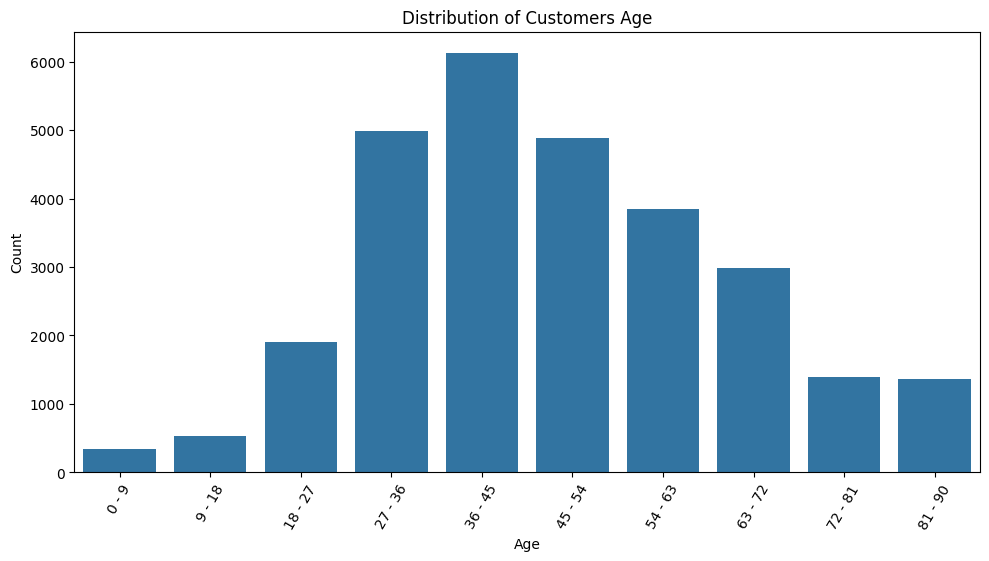

C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\2082419686.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


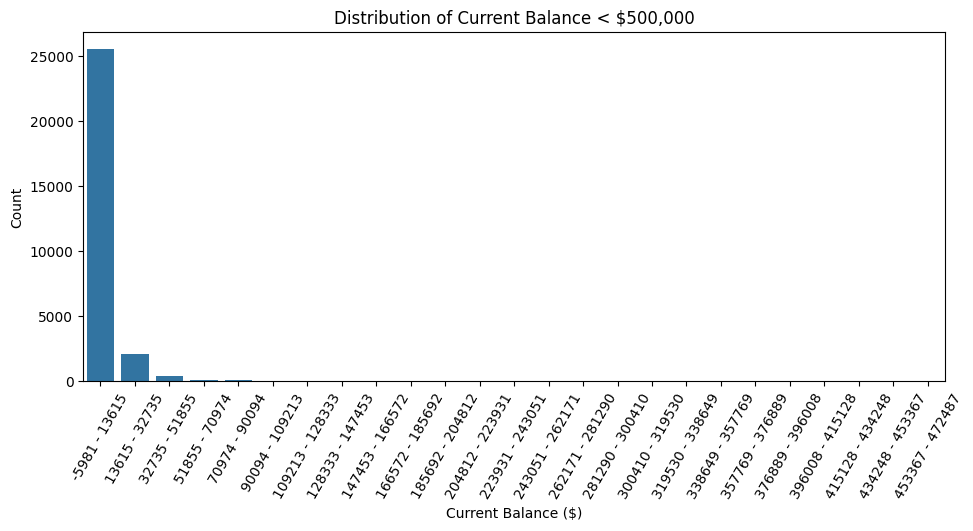

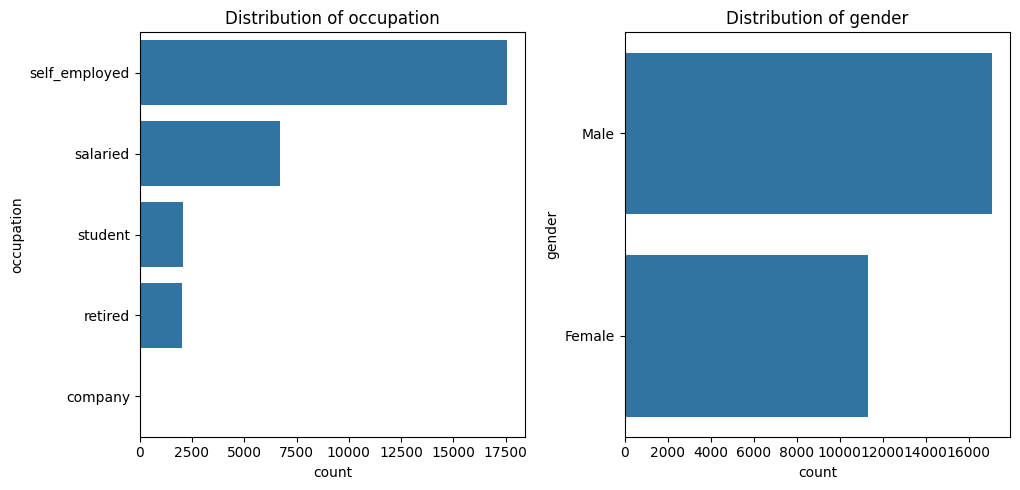

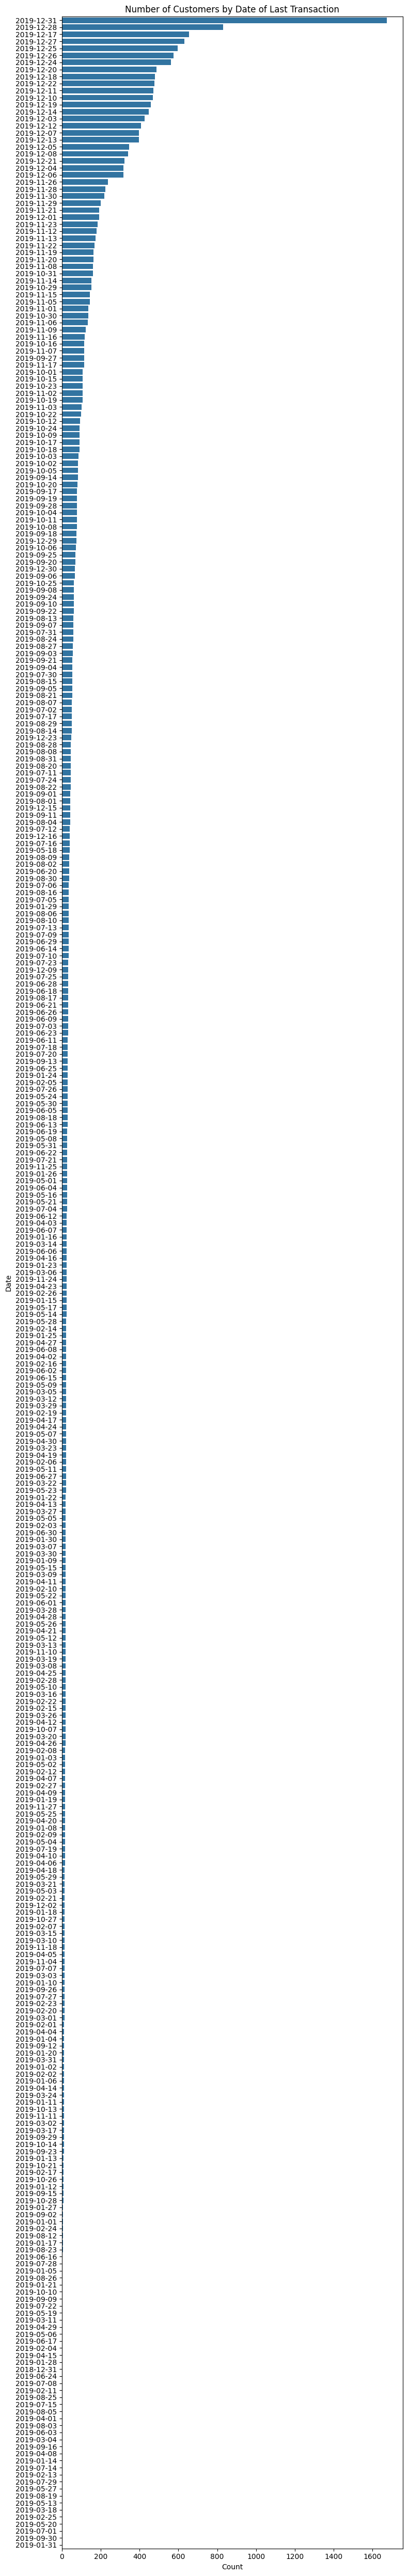

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Bin the ages into 10 bins
age_bins = pd.cut(raw['age'], bins=10)

# Plot the count of age bins
plt.figure(figsize=(10, 6))
sns.countplot(x=age_bins)
plt.xticks(rotation=60)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Customers Age')
plt.tight_layout()
labels = [f'{int(cat.left)} - {int(cat.right)}' for cat in age_bins.cat.categories]
plt.gca().set_xticklabels(labels)
plt.show()

#Create new df to plot balance distribution below 500,000
balance_df = raw.loc[raw['current_balance'] <= 500000, ['current_balance']].copy()
balance_bins = pd.cut(balance_df['current_balance'], bins=25)

plt.figure(figsize=(10, 6))
sns.countplot(x=balance_bins)
plt.xticks(rotation=60)
plt.xlabel('Current Balance ($)')
plt.ylabel('Count')
plt.title('Distribution of Current Balance < $500,000')
plt.tight_layout()
labels = [f'{int(cat.left)} - {int(cat.right)}' for cat in balance_bins.cat.categories]
plt.gca().set_xticklabels(labels)
plt.show()

#Plot categorical values
categorical_vars = ['occupation', 'gender']
n_categorical = len(categorical_vars)

fig, axes = plt.subplots(1, 4, figsize=(20, 5 * 1))
axes = axes.flatten()
for i, var in enumerate(categorical_vars):
    sns.countplot(y=raw[var], ax=axes[i], order=raw[var].value_counts().index)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_categorical, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Plot last transaction date
raw['last_transaction'] = pd.to_datetime(raw['last_transaction'])

plt.figure(figsize=(8, 50))
sns.barplot(y=raw['last_transaction'].dt.date.value_counts().index,
            x=raw['last_transaction'].dt.date.value_counts())
plt.xlabel('Count')
plt.ylabel('Date')
plt.title('Number of Customers by Date of Last Transaction')
plt.tight_layout()
plt.show()


## Feature Engineering

Since the churn variable already exists, we do not need to conduct any feature engineering to acquire this. Nevertheless, there are still other opportunities to summarize the data set and create new features.

Firstly, the two cateogrical variables, gender and occupation, need to be encoded. In this case we'll use one-hot encoding, which splits the categories into multiple columns and then denotes the correspondence by 1 for true and 0 for false. If the variable has many options, this can severly inflate the data set, hence, it is to be used with caution.

Secondly, the variable "last_transaction" can be easily converted to a numerical variable by counting the days since the last transaction. Since this data set is a bit outdated with the most recent date being 12/31/2019, we decided to pick 01/01/2020 as the "current date".

Lastly, we are computing a ration between the average monthly balance of the last two quarters and the current balance. This should give us a new measure that will show the proportion of the current balance compared to a long-term average. This benefits us in two ways: (1) it should not be correlated with either feature, introducing a new variable for greater complexity of the data set. (2) the new measure being a proportion will highlight large differences between the two, which highlights on balances that have gone down significantly.

In [10]:
from datetime import datetime as dt
# One-hot encode categorical variables
raw = pd.get_dummies(raw, columns=['gender', 'occupation'], drop_first=True)

#Days since last transaction
raw['last_transaction'] = pd.to_datetime(raw['last_transaction'], errors='coerce')

current_date = dt.strptime('2020-01-01', '%Y-%m-%d') # or use a specific reference date if required
raw['days_since_last_trans'] = (current_date - raw['last_transaction']).dt.days

raw['days_since_last_trans'].fillna(raw['days_since_last_trans'].mode()[0], inplace=True)

# Average monthly balance over the past two quarters compared to current balance
raw['avg_balance_ratio_Q'] = raw['current_balance'] / raw['average_monthly_balance_prevQ']
raw['avg_balance_ratio_Q2'] = raw['current_balance'] / raw['average_monthly_balance_prevQ2']

C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\963529927.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw['days_since_last_trans'].fillna(raw['days_since_last_trans'].mode()[0], inplace=True)


Lastly for the EDA, a correlation heatmap of all numerical values shows that most features are not very correlated with each other. The only features that are, are the balance measures. This is not surprisng, since the previous_month_end_balance should be correlated with the current balance, and so on and so forth. As can be seen, the newly engineered ration variable is not correlated with any of the other balance features.

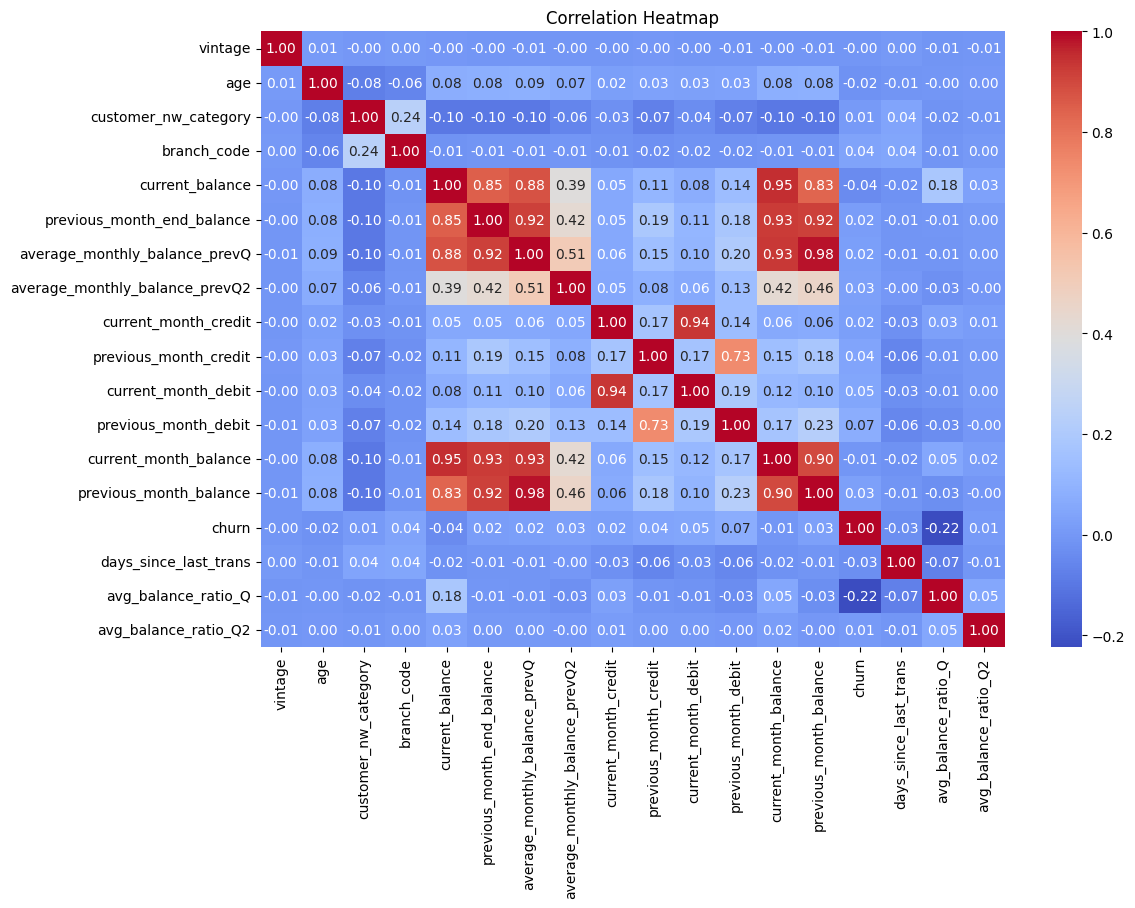

In [11]:
# Remove non-numeric columns for correlation heatmap
numeric_df = raw.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Machine Learning

### Preprocess Data

Before the machine learning algorithms can be implemented, the data set needs to be preprocessed. This includes identifiying the feature and target variables, splitting the data set, and then scaling the data set.

Below, the logistic regression, random forest, and neural network will be implemented. This is followed by an overall performance comparison between the three models. Then, the feature importances are investigated. The section conludes by implementing and analyzing the K-Means clustering algorithm.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import statsmodels
import random

random.seed(2024)
# Define features and target
features = ['vintage', 'age', 'customer_nw_category', 'branch_code', 'current_balance', 'previous_month_end_balance',
            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2', 'current_month_credit', 
            'previous_month_credit', 'current_month_debit', 'previous_month_debit', 'current_month_balance', 
            'previous_month_balance', 'gender_Male', 'occupation_retired', 'occupation_salaried', 
            'occupation_self_employed', 'occupation_student', 'days_since_last_trans', 'avg_balance_ratio_Q', 
            'avg_balance_ratio_Q2']

X = raw[features]
y = raw['churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=958, stratify=y)

# Standardize features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [31]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

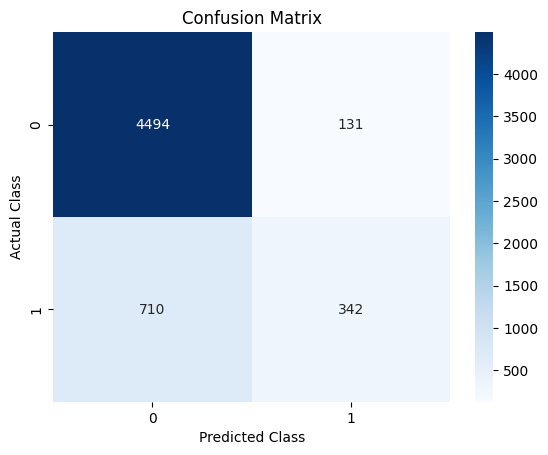


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4625
           1       0.72      0.33      0.45      1052

    accuracy                           0.85      5677
   macro avg       0.79      0.65      0.68      5677
weighted avg       0.84      0.85      0.83      5677



In [32]:
# Predictions
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

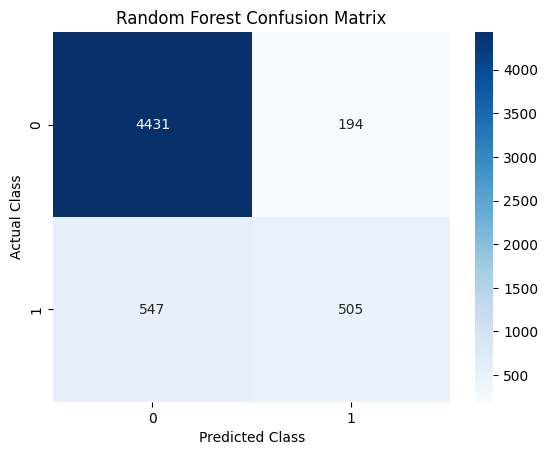


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4625
           1       0.72      0.48      0.58      1052

    accuracy                           0.87      5677
   macro avg       0.81      0.72      0.75      5677
weighted avg       0.86      0.87      0.86      5677



In [44]:
# Predictions
y_rf_pred = random_forest_model.predict(X_test)
y_rf_pred_proba = random_forest_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, y_rf_pred)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_rf_pred))

### Neural Network

In [35]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(random_state=42, hidden_layer_sizes=(64, 64), max_iter=300, solver='adam', activation='relu')
nn_model.fit(X_train, y_train)

C:\Users\f9tbqno\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=300, random_state=42)

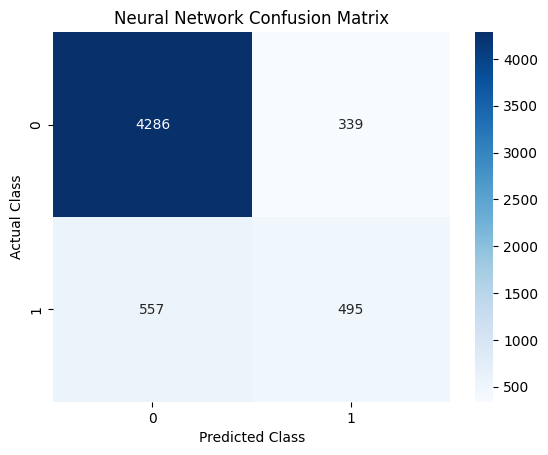


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4625
           1       0.59      0.47      0.52      1052

    accuracy                           0.84      5677
   macro avg       0.74      0.70      0.72      5677
weighted avg       0.83      0.84      0.83      5677



In [36]:
# Predictions
y_nn_pred = nn_model.predict(X_test)
y_nn_pred_proba = nn_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
nn_conf_matrix = confusion_matrix(y_test, y_nn_pred)
sns.heatmap(nn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_nn_pred))

### Model Evaluation

All three algorithms have performed reasonably well. Looking at the accuracy measures below shows that the random forest algorithm has performed best with 87% accuracy. However, in terms of precision, the logistic regression actually has performed better. This suggests that the logistic regression may be more biased than the random forest. Depending in which direction this precision goes, this may be good or bad. While the neural network has not underperformed the logistic regression and the random forest, it is possible that the data set is too small with 28,000 observations. 
This makes sense, since neural network need at minimum hundreds of thousands of data points. Therefore, if transaction details could be included, for example, neural networks may be a better choice. In this case, the focus should lie on the random forest. This could be contrasted with implementing an XGBoost algorithm, although they will likely not perform much differently.

The ROC curve shows similarly the result that it is apparent when investigating the accuracy measure.

In [45]:
models = ["Logistic Regression", "Random Forest", "Neural Network"]
accuracy = []
precision = []
recall = []
f1_score = []
roc_auc = []

# Logistic Regression metrics
lr_accuracy = logistic_model.score(X_test, y_test)
lr_classification_report = classification_report(y_test, y_pred, output_dict=True)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba)

accuracy.append(lr_accuracy)
precision.append(lr_classification_report['1']['precision'])
recall.append(lr_classification_report['1']['recall'])
f1_score.append(lr_classification_report['1']['f1-score'])
roc_auc.append(lr_roc_auc)

# Random Forest metrics
rf_accuracy = random_forest_model.score(X_test, y_test)
rf_classification_report = classification_report(y_test, y_rf_pred, output_dict=True)
rf_roc_auc = roc_auc_score(y_test, y_rf_pred_proba)

accuracy.append(rf_accuracy)
precision.append(rf_classification_report['1']['precision'])
recall.append(rf_classification_report['1']['recall'])
f1_score.append(rf_classification_report['1']['f1-score'])
roc_auc.append(rf_roc_auc)

# Neural Network metrics
nn_accuracy = nn_model.score(X_test, y_test)
nn_classification_report = classification_report(y_test, y_nn_pred, output_dict=True)
nn_roc_auc = roc_auc_score(y_test, y_nn_pred_proba)

accuracy.append(nn_accuracy)
precision.append(nn_classification_report['1']['precision'])
recall.append(nn_classification_report['1']['recall'])
f1_score.append(nn_classification_report['1']['f1-score'])
roc_auc.append(nn_roc_auc)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
    "ROC-AUC": roc_auc
})

# Display the table
print("\nEvaluation Metrics for all three models:")
print(metrics_df)


Evaluation Metrics for all three models:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.851858   0.723044  0.325095  0.448525  0.795617
1        Random Forest  0.869473   0.722461  0.480038  0.576813  0.838732
2       Neural Network  0.842170   0.593525  0.470532  0.524920  0.787254


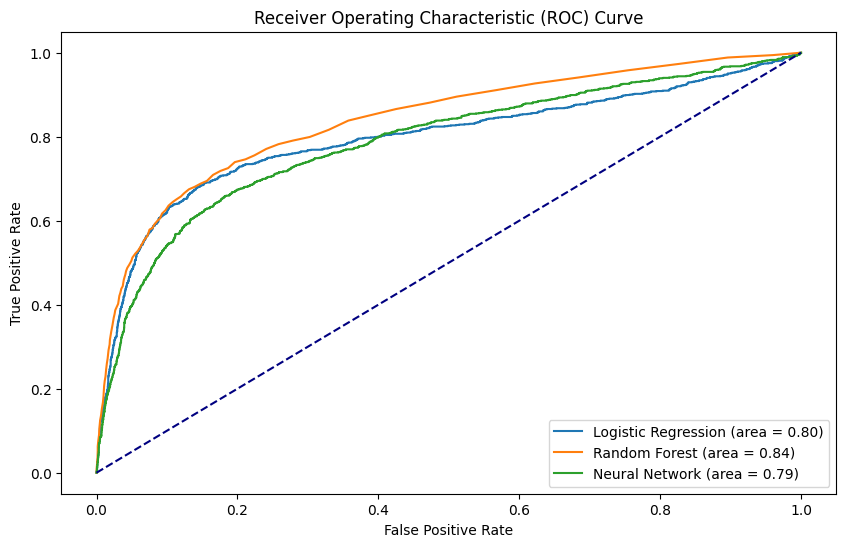

In [40]:
plt.figure(figsize=(10, 6))

# Logistic Regression ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % roc_auc_lr)

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_pred_proba)
roc_auc_rf = roc_auc_score(y_test, y_rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % roc_auc_rf)

# Neural Network ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_nn_pred_proba)
roc_auc_nn = roc_auc_score(y_test, y_nn_pred_proba)
plt.plot(fpr_nn, tpr_nn, label='Neural Network (area = %0.2f)' % roc_auc_nn)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

Since the random forest was the best performing model, we can utilize its transparency and explainability to investigate the feature importances. The three most important features are occupation_student, current_balance, days_since_last_trans. The very big surprise is the occupation_student variable being the most important variable. The bar plot shows the student column and is 0 if they are not a student, and 1 if they are a student. It appears that there is a much higher number of students that are not churning. This is likely due to the fact that students are bound at their parents' home, and that their relationship with the bank is not yet really important.

On the other hand, the current balance and days since last transaction features are no surprise to be among the most important features. As discussed above, if the day since last transaction is high, and the current balance is very low or even 0, the customer has churned most likely. 

It is still interesting to investigate further predictive features of churn, some that may not be as obvious. For example, detailed transaction measurements may have been interesting to implement, as they may be predictive of churning earlier on than are balance, since that is fluctuating feature. Nevertheless, the likelihood of churn clearly increases the longer ago the last transaction happened. 

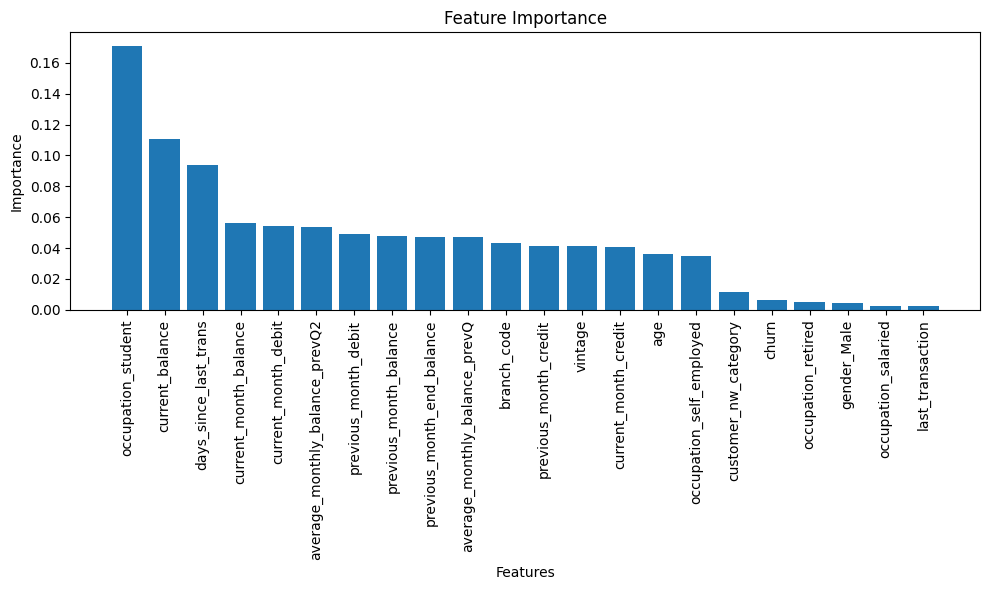

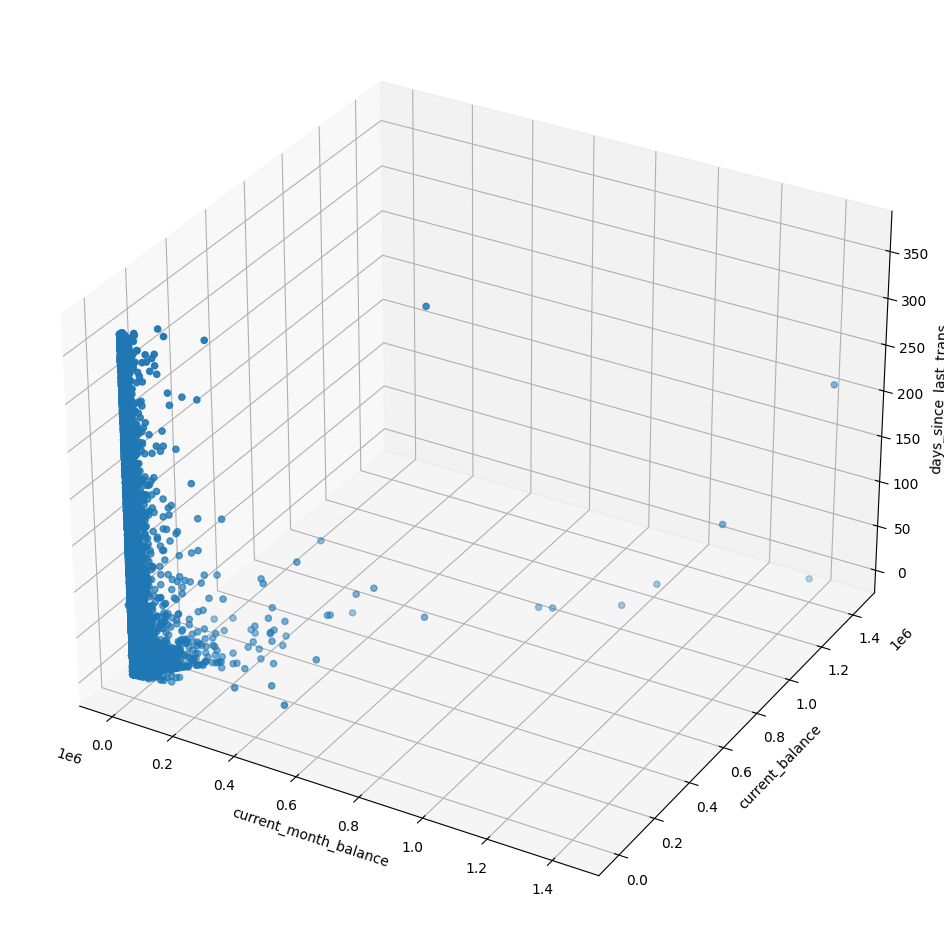

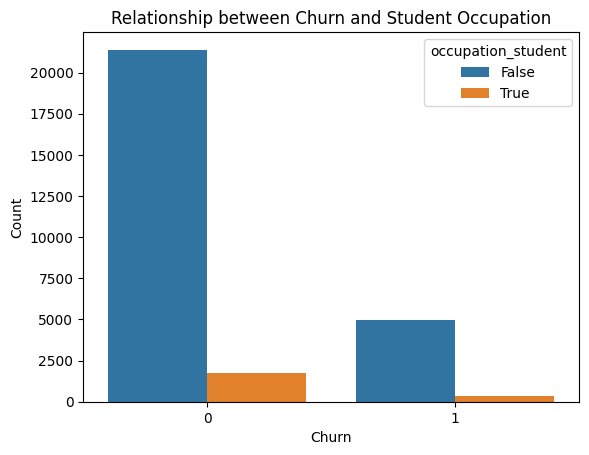

In [50]:
feature_importances = random_forest_model.feature_importances_

# Get the names of the features
feature_names = raw.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

#Student Occupation vs. Churn
sns.countplot(x='churn', hue='occupation_student', data=raw)

# Add labels and title
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Relationship between Churn and Student Occupation')

# Show the plot
plt.show()

### K-Means Clustering

The K-Means clustering algorithm is the most divergent of the four machine learning algorithms. It is an unsupervised algorithm, meaning it does not require labels, but therefore also no performance metrics can be computed. For the current project, it is a nice supplemental algorithm that can give further understanding to the resuts above. 

There are some other clustering algorithms, but K-Means does well with higher dimensionality and more features.

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random

random.seed(958)
#Drop target & date column
features_for_clustering = raw.drop(columns=['churn', 'last_transaction'])

#Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=1403)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster information to the original dataframe
raw['cluster'] = clusters


Using a k = 4, the plot below shows that the largest cluster was the second one. Using a one-way ANOVA to compute the differences between the clusters within each feature shows which features exhibit the biggest variance. Additionally, we can use PCA to create two components of the data set that we can then plot and group by the clusters. The scatterplot shows that some of the clusters are very intertwined, while some others are very separated. This suggests that the data set is quite complex, and in further steps some features could be excluded to reduce this complexity.

C:\Users\f9tbqno\AppData\Local\Temp\ipykernel_20676\1287836752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw, x='cluster', palette='viridis')


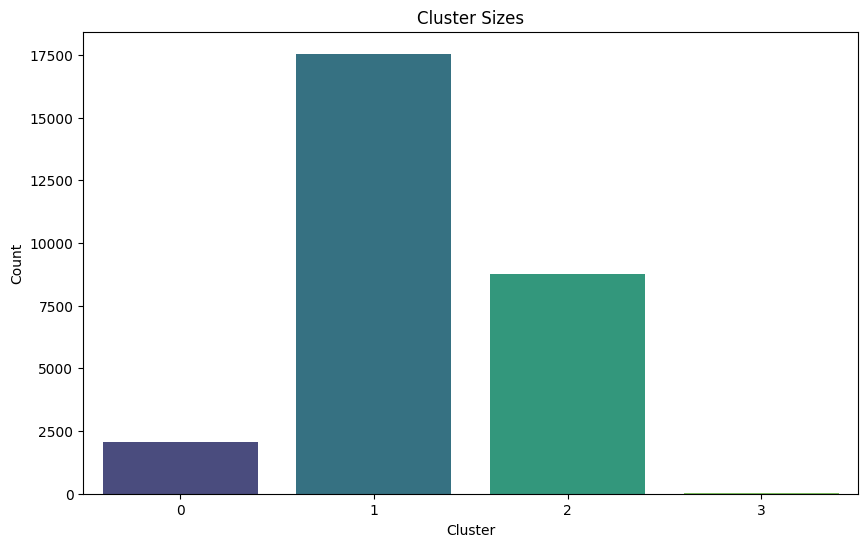


ANOVA P-Values for Features:
                           Feature  ANOVA_P_Value
10             current_month_debit   0.000000e+00
16             occupation_salaried   0.000000e+00
15              occupation_retired   0.000000e+00
13          previous_month_balance   0.000000e+00
12           current_month_balance   0.000000e+00
17        occupation_self_employed   0.000000e+00
8             current_month_credit   0.000000e+00
18              occupation_student   0.000000e+00
6    average_monthly_balance_prevQ   0.000000e+00
5       previous_month_end_balance   0.000000e+00
4                  current_balance   0.000000e+00
1                              age   0.000000e+00
7   average_monthly_balance_prevQ2   0.000000e+00
11            previous_month_debit  2.532879e-282
14                     gender_Male  1.920827e-246
9            previous_month_credit  5.479033e-163
3                      branch_code   3.054844e-21
2             customer_nw_category   1.972631e-19
19           days_si

C:\Users\f9tbqno\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=raw, x='cluster', palette='viridis')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

from scipy.stats import f_oneway
# Perform ANOVA for each feature
anova_results = {}
for feature in features_for_clustering.columns:
    cluster_groups = [raw[raw['cluster'] == cluster][feature] for cluster in range(kmeans.n_clusters)]
    anova_results[feature] = f_oneway(*cluster_groups).pvalue

anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'ANOVA_P_Value'])
anova_results_df.sort_values(by='ANOVA_P_Value', inplace=True)
print("\nANOVA P-Values for Features:")
print(anova_results_df)

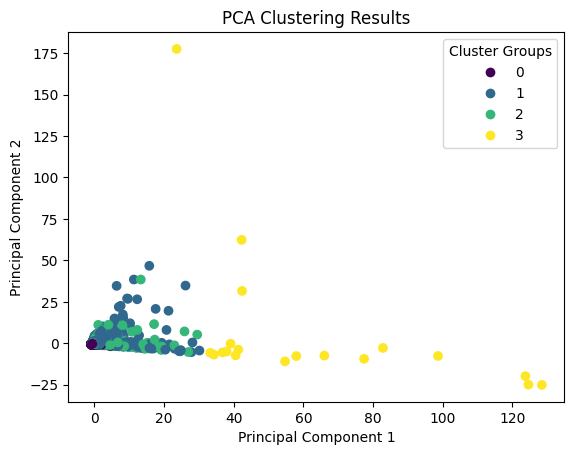

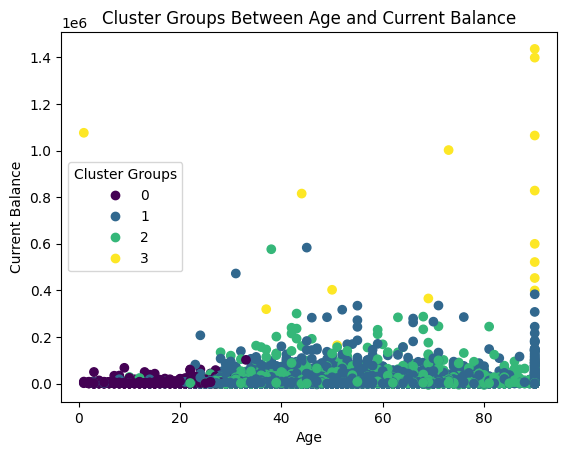

In [16]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the data points with different colors representing the clusters
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clustering Results')
legend_labels = list(set(clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Cluster Groups')
plt.show()

#Plot Age vs. Current Balance
scatter = plt.scatter(raw['age'], raw['current_balance'], c=clusters)
plt.xlabel('Age')
plt.ylabel('Current Balance')
plt.title('Cluster Groups Between Age and Current Balance')
legend_labels = list(set(clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Cluster Groups')
plt.show()


## Conclusion

The current project aimed to answer which variables are most predictive of customer churn in a bank, and why people churn. Expectedly, variables that measure engagement, in this case, account balance and transactions, are most predictive of churn. However, this does not tell us why people churn. To better answer this question, we'll need more information on the customers, including their detailed transactions, which products they have with the bank. This can then give rise to better anaylsis of the reasoing behind churn. Additionally, social media may be a good source to conduct sentiment analysis, and perhaps the bank has received a bad rap that led to churn. This can be aided by an estimated churn date, which could be telling of possible waves of churns.

## Essay

Investigating Customer Churn in Banking: An Analytical Approach

Customer churn, where customers leave a business, poses a significant challenge across industries. In banking, churn is critical as losing one customer can result in the loss of revenue across multiple product lines. This project aims to understand factors leading to customer churn in banking using analytics and machine learning techniques.

The dataset from Kaggle includes variables such as customer age, gender, occupation, balance details, and churn status. Initial exploration involves loading the data and examining its structure. Most variables are continuous, with important categorical variables like gender and occupation. 
Handling missing data is crucial. Variables like 'city' and 'dependents' with missing values are excluded. Critical variables 'gender' and 'occupation' are imputed using mode imputation to ensure no loss of essential information for churn prediction. Summary statistics reveal mostly intuitive values, except for an outlier in 'current_balance'. This outlier is excluded to maintain analysis integrity.

Feature engineering creates insightful variables. One-hot encoding converts categorical variables 'gender' and 'occupation' into numerical format. The 'last_transaction' date is transformed into a numerical variable representing days since the last transaction. Ratios between the current balance and average balances over the last two quarters are also computed.

Correlation analysis using a heatmap indicates that most numerical features are not highly correlated, except for balance-related features. Newly engineered ratio variables show minimal correlation, adding valuable complexity without redundancy.

Three machine learning algorithms—Logistic Regression, Random Forest, and Neural Network—predict customer churn. The data is split into training and testing sets, standardized, and then used to train the models. Each model's performance is evaluated based on accuracy, precision, recall, f1-score, and ROC-AUC scores. 
The Random Forest model achieves the highest accuracy at 87%, with Logistic Regression closely following in precision. The Neural Network model performs slightly worse, likely due to the dataset's modest size. These results highlight Random Forest as the preferred model for this analysis.

Feature importances in the Random Forest model reveal key insights. Top predictors of churn include 'occupation_student', 'current_balance', and 'days_since_last_trans'. Interestingly, 'occupation_student' is a significant predictor, suggesting students are less likely to churn, possibly due to their stable residential status.
To provide further insights, K-Means clustering, an unsupervised algorithm, is implemented. Using a k-value of 4, clustering analysis highlights the dataset's complexity. ANOVA tests show that features like 'current_month_debit', 'occupation_salaried', and 'days_since_last_trans' exhibit significant variance across clusters. PCA visualization illustrates the intertwined nature of some clusters, suggesting that certain features could be excluded in future analysis to reduce complexity.

The project concludes that engagement-related variables like account balance and transaction history are key predictors of customer churn. However, deeper insights into churn reasons require detailed customer information, including transaction records and product usage details. Sentiment analysis from social media data could provide valuable context, particularly if the bank has received negative feedback leading to churn. Understanding these nuances can help banks implement more effective retention strategies.

This project underscores the critical role of advanced analytics and machine learning in addressing customer churn. It sets a robust framework for future investigations and enhancements, aiming to provide banking institutions with actionable insights to drive better customer engagement and reduce churn.
